In [1]:
cd ..

/lus/grand/projects/STlearn/4D_fMRI_Transformer


In [2]:
import pytorch_model_summary
import torch
from modules.model import Encoder_Transformer_Decoder,Encoder_Transformer_finetune,AutoEncoder, MobileNet_v2_Transformer_finetune,MobileNet_v3_Transformer_finetune

In [5]:
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
from modules.data_preprocess_and_load.data_module3 import fMRIDataModule
import os
def get_arguments(base_path):
    """
    handle arguments from commandline.
    some other hyper parameters can only be changed manually (such as model architecture,dropout,etc)
    notice some arguments are global and take effect for the entire three phase training process, while others are determined per phase
    """
    parser = ArgumentParser(add_help=False, formatter_class=ArgumentDefaultsHelpFormatter)
    parser.add_argument('--exp_name', type=str,default="baseline") 
    parser.add_argument('--base_path', default=base_path)
    parser.add_argument('--step', default='4', choices=['1','2','3','4'], help='which step you want to run')
    
    parser.add_argument('--cuda', default=True)
    parser.add_argument('--log_dir', type=str, default=os.path.join(base_path, 'runs'))
    parser.add_argument('--block_type', default='green', choices=['MobileNet_v2','MobileNet_v3','green'])

    
    parser.add_argument('--use_optuna', action='store_true', help='whether to use optuna hyperparameter training. DB location is determined by exp_name')
    parser.add_argument('--use_best_params_from_optuna', action='store_true', help='load best params from Optuna results in DB. --use_optuna should be False if this argument is True')
    parser.add_argument('--num_trials', default=10, help='how many trials')
    parser.add_argument('--n_startup_trials', default=2, help='argument for MedianPruner, Pruning is disabled until the given number of trials finish in the same study.')
    parser.add_argument('--n_warmup_steps', default=5, help='argument for MedianPruner, epoch is same as step in our code. Pruning is disabled until the trial exceeds the given number of step. Note that this feature assumes that step starts at zero.')
    parser.add_argument('--interval_steps', default=1, help='argument for MedianPruner, Interval in number of steps between the pruning checks, offset by the warmup steps. If no value has been reported at the time of a pruning check, that particular check will be postponed until a value is reported.')
    # parser.add_argument('--random_TR', action='store_false') #True면(인자를 넣어주지 않으면) 전체 sequence 로부터 random sampling(default). False면 (--random_TR 인자를 넣어주면) 0번째 TR부터 sliding window
    
    # loss-related
    parser.add_argument('--intensity_factor', default=1)
    parser.add_argument('--perceptual_factor', default=1)
    parser.add_argument('--which_perceptual', default='vgg', choices=['vgg','densenet3d'])
    parser.add_argument('--reconstruction_factor', default=1)
    
    # model related
    parser.add_argument('--transformer_hidden_layers', type=int,default=16)
    parser.add_argument('--transformer_num_attention_heads',type=int, default=16)
    parser.add_argument('--transformer_emb_size',type=int ,default=2640)
    parser.add_argument('--running_mean_size', default=5000)
    
    # DDP configs:
    parser.add_argument('--world_size', default=-1, type=int, 
                        help='number of nodes for distributed training')
    parser.add_argument('--rank', default=-1, type=int, 
                        help='node rank for distributed training')
    parser.add_argument('--local_rank', default=-1, type=int, 
                        help='local rank for distributed training')
    parser.add_argument('--dist_backend', default='nccl', type=str, 
                        help='distributed backend')
    parser.add_argument('--init_method', default='env', type=str, choices=['file','env'], help='DDP init method')
    parser.add_argument('--distributed', default=False)

    # AMP configs:
    parser.add_argument('--amp', action='store_false')
    parser.add_argument('--gradient_clipping', action='store_true')
    #parser.add_argument('--opt_level', default='O1', type=str,
    #                    help='opt level of amp. O1 is recommended')
    
    # Gradient accumulation
    parser.add_argument("--accumulation_steps", default=1, type=int,required=False,help='mini batch size == accumulation_steps * args.train_batch_size')
    
    # Nsight profiling
    parser.add_argument("--profiling", action='store_true')
   
    ##phase 1
    parser.add_argument('--task_phase1', type=str, default='autoencoder_reconstruction')
    parser.add_argument('--batch_size_phase1', type=int, default=8, help='for DDP, each GPU processes batch_size_pahse1 samples') #이걸.. 잘게 쪼개볼까? 원래는 4였음.
    parser.add_argument('--validation_frequency_phase1', type=int, default=10000000) # 11 for test #original: 10000) #원래는 1000이었음 -> 약 7분 걸릴 예정.
    parser.add_argument('--nEpochs_phase1', type=int, default=20) #epoch는 10개인 걸로~
    parser.add_argument('--augment_prob_phase1', default=0)
    parser.add_argument('--optim_phase1', default='AdamW')
    parser.add_argument('--weight_decay_phase1', default=1e-7)
    parser.add_argument('--lr_policy_phase1', default='step', choices=['step','SGDR'], help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase1', type=float, default=1e-3)
    parser.add_argument('--lr_gamma_phase1', type=float, default=0.97)
    parser.add_argument('--lr_step_phase1', type=int, default=500)
    parser.add_argument('--lr_warmup_phase1', type=int, default=500)

    ##phase 2
    parser.add_argument('--task_phase2', type=str, default='transformer_reconstruction')
    parser.add_argument('--batch_size_phase2', type=int, default=4) #원래는 1이었음
    parser.add_argument('--validation_frequency_phase2', type=int, default=10000000) # 11 for test original: 10000) #원래는 500이었음
    parser.add_argument('--optim_phase2', default='Adam')
    parser.add_argument('--nEpochs_phase2', type=int, default=20)
    parser.add_argument('--augment_prob_phase2', default=0)
    parser.add_argument('--weight_decay_phase2', default=1e-7)
    parser.add_argument('--lr_policy_phase2', default='step', choices=['step','SGDR'], help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase2', type=float, default=1e-4)
    parser.add_argument('--lr_gamma_phase2', type=float, default=0.97)
    parser.add_argument('--lr_step_phase2', type=int, default=1000)
    parser.add_argument('--lr_warmup_phase2', type=int, default=500)
    parser.add_argument('--model_weights_path_phase1', default=None)
    parser.add_argument('--use_cont_loss', default=False)
    parser.add_argument('--use_mask_loss', default=False)

    ##phase 3
    parser.add_argument('--task_phase3', type=str, default='fine_tune')
    parser.add_argument('--batch_size_phase3', type=int, default=4) #원래는 3이었음
    parser.add_argument('--validation_frequency_phase3', type=int, default=10000) # 11 for test # original: 10000) #원래는 200이었음
    parser.add_argument('--nEpochs_phase3', type=int, default=20)
    parser.add_argument('--augment_prob_phase3', default=0)
    parser.add_argument('--optim_phase3', default='Adam')
    parser.add_argument('--weight_decay_phase3', default=1e-2)
    parser.add_argument('--lr_policy_phase3', default='step', choices=['step','SGDR'], help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase3', type=float, default=1e-4)
    parser.add_argument('--lr_gamma_phase3', type=float, default=0.9)
    parser.add_argument('--lr_step_phase3', type=int, default=1500)
    parser.add_argument('--lr_warmup_phase3', type=int, default=100)
    parser.add_argument('--model_weights_path_phase2', default=None)
    
    ##phase 4 (test)
    parser.add_argument('--task_phase4', type=str, default='test')
    parser.add_argument('--model_weights_path_phase3', default=None)
    parser.add_argument('--batch_size_phase4', type=int, default=4)
    parser.add_argument('--nEpochs_phase4', type=int, default=20)
    parser.add_argument('--augment_prob_phase4', default=0)
    parser.add_argument('--optim_phase4', default='Adam')
    parser.add_argument('--weight_decay_phase4', default=1e-2)
    parser.add_argument('--lr_policy_phase4', default='step', choices=['step','SGDR'], help='learning rate policy: step|SGDR')
    parser.add_argument('--lr_init_phase4', type=float, default=1e-4)
    parser.add_argument('--lr_gamma_phase4', type=float, default=0.9)
    parser.add_argument('--lr_step_phase4', type=int, default=1500)
    parser.add_argument('--lr_warmup_phase4', type=int, default=100)
    
    temp_args, _ = parser.parse_known_args()
    
    # Set dataset-specific Arguments
    Dataset = fMRIDataModule
    
    parser = Dataset.add_data_specific_args(parser)
    args = parser.parse_args(args=[])
    return args

In [6]:
from modules.utils import *
import time
from modules.utils import *
from modules.trainer import Trainer

base_path = os.getcwd() 

args = get_arguments(base_path)
args.image_path = '/lus/grand/projects/STlearn/HCP_MNI_to_TRs'
args.experiment_folder = '/lus/grand/projects/STlearn/4D_fMRI_Transformer/experiments/S1200_fine_tune_binary_classification_sex_from_scratch_split_1'
args.experiment_title = args.experiment_folder
args.return_value = True
args = sort_args('4', vars(args))

kwargs = args

S = 'test'
trainer = Trainer(sets=S,**kwargs)

#trainer.train_loader.dataset.dataset[0]


loading split file : /lus/grand/projects/STlearn/4D_fMRI_Transformer/data/splits/S1200/split_fixed_1.txt
length of train_idx: 44700
length of val_idx: 9546
length of test_idx: 9676
return_value: True
loading checkpoint from /lus/grand/projects/STlearn/4D_fMRI_Transformer/experiments/S1200_fine_tune_binary_classification_sex_from_scratch_split_1/S1200_fine_tune_binary_classification_sex_from_scratch_split_1_epoch_7_batch_index_279_BEST_val_accuracy.pth
loading parameters onto new model...
notice: named parameter - transformer.cls_embedding.0.weight is randomly initialized
notice: named parameter - transformer.cls_embedding.0.bias is randomly initialized


/home/junbeom/.conda/envs/3DCNN/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Training start from epoch 8 and learning rate 9e-05.
notice: changed layers in perceptual back to old version
using binary_classification loss


In [8]:
model = trainer.model
for name, module in model.named_modules():
    if 'attention.self.dropout' in name:
        print(name)

transformer.bert.encoder.layer.0.attention.self.dropout
transformer.bert.encoder.layer.1.attention.self.dropout
transformer.bert.encoder.layer.2.attention.self.dropout
transformer.bert.encoder.layer.3.attention.self.dropout
transformer.bert.encoder.layer.4.attention.self.dropout
transformer.bert.encoder.layer.5.attention.self.dropout
transformer.bert.encoder.layer.6.attention.self.dropout
transformer.bert.encoder.layer.7.attention.self.dropout
transformer.bert.encoder.layer.8.attention.self.dropout
transformer.bert.encoder.layer.9.attention.self.dropout
transformer.bert.encoder.layer.10.attention.self.dropout
transformer.bert.encoder.layer.11.attention.self.dropout
transformer.bert.encoder.layer.12.attention.self.dropout
transformer.bert.encoder.layer.13.attention.self.dropout
transformer.bert.encoder.layer.14.attention.self.dropout
transformer.bert.encoder.layer.15.attention.self.dropout


In [9]:
model = trainer.model
for name, module in model.named_modules():
    print(name)


encoder
encoder.down_block1
encoder.down_block1.conv0
encoder.down_block1.sp_drop0
encoder.down_block1.green0
encoder.down_block1.green0.block
encoder.down_block1.green0.block.group_norm0
encoder.down_block1.green0.block.relu0
encoder.down_block1.green0.block.conv0
encoder.down_block1.green0.block.group_norm1
encoder.down_block1.green0.block.relu1
encoder.down_block1.green0.block.conv2
encoder.down_block1.downsize_0
encoder.down_block2
encoder.down_block2.green10
encoder.down_block2.green10.block
encoder.down_block2.green10.block.group_norm0
encoder.down_block2.green10.block.relu0
encoder.down_block2.green10.block.conv0
encoder.down_block2.green10.block.group_norm1
encoder.down_block2.green10.block.relu1
encoder.down_block2.green10.block.conv2
encoder.down_block2.green11
encoder.down_block2.green11.block
encoder.down_block2.green11.block.group_norm0
encoder.down_block2.green11.block.relu0
encoder.down_block2.green11.block.conv0
encoder.down_block2.green11.block.group_norm1
encoder.dow

### Attention visualization

In [10]:
class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attention.self.dropout',head_fusion="mean",
                discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)
        
        self.attentions = []
    def get_attention(self, module, input, output):
        #print(output)
        self.attentions.append(output.cpu())
    
    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)
            #print(output)
        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [11]:
def rollout(attentions, discard_ratio, head_fusion):
    #print(len(attentions)) # 16 개의 hidden layer 층
    #print(attentions[0].shape) # torch.Size([1, 16, 21, 21] # batch, number of head, width, width
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions: # 각 layer 마다
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1) # 1 * 21 * 21
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"
            
            # Drop the lowest attentions, but don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0),-1) # 1 * (21 * 21)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), dim=-1, largest=False)
            indices = indices[indices != 0]
            flat[0, indices] = 0 # 낮은 attention은 0으로 만듦.
            
            I = torch.eye(attention_heads_fused.size(-1)) # 21 * 21
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)
            
            result = torch.matmul(a, result) # 모든 layer의 attention map (21 * 21)을 서로 matmul
        
        # result : 1, 21,21
        mask = result[0,0,1:].numpy() # 20 # 196
        #width = int(mask.size(-1)**0.5)
        #mask = mask.reshape(width, width).numpy()
        mask = mask/ np.max(mask)
        return mask

### Define input tensor and print prediction and ground truth

In [16]:
input_tensor = trainer.test_loader.dataset.dataset[0]['fmri_sequence'].unsqueeze(0).float()
torch.sigmoid(trainer.model(input_tensor))

tensor([[0.0005]], grad_fn=<SigmoidBackward0>)

In [15]:
trainer.train_loader.dataset.dataset[0]['sex']

0

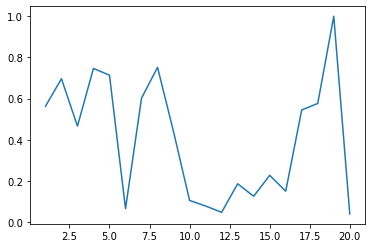

In [14]:
# from vit_grad_rollout import VITAttentionGradRollout
visualization = VITAttentionRollout(model, discard_ratio=0.9, head_fusion='max')
output= visualization(input_tensor)


import matplotlib.pyplot as plt
plt.plot(np.arange(1,21),output)

In [17]:
input_tensor = trainer.test_loader.dataset.dataset[1000]['fmri_sequence'].unsqueeze(0).float()
torch.sigmoid(trainer.model(input_tensor))

tensor([[0.9991]], grad_fn=<SigmoidBackward0>)

In [19]:
trainer.train_loader.dataset.dataset[1000]['sex']

1.0

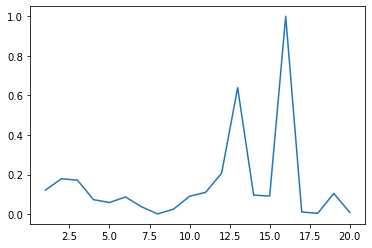

In [20]:
# from vit_grad_rollout import VITAttentionGradRollout
visualization = VITAttentionRollout(model, discard_ratio=0.9, head_fusion='max')
output= visualization(input_tensor)


import matplotlib.pyplot as plt
plt.plot(np.arange(1,21),output)

In [ ]:
pip install grad_cam

## pytorch gradcam 

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, 
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

model = trainer.model
target_layers = [model.regression_head]
input_tensor = input_tensor # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(0)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

In [14]:
model = trainer.model
for name, module in model.named_modules():
    print(name)


encoder
encoder.down_block1
encoder.down_block1.conv0
encoder.down_block1.sp_drop0
encoder.down_block1.green0
encoder.down_block1.green0.block
encoder.down_block1.green0.block.group_norm0
encoder.down_block1.green0.block.relu0
encoder.down_block1.green0.block.conv0
encoder.down_block1.green0.block.group_norm1
encoder.down_block1.green0.block.relu1
encoder.down_block1.green0.block.conv2
encoder.down_block1.downsize_0
encoder.down_block2
encoder.down_block2.green10
encoder.down_block2.green10.block
encoder.down_block2.green10.block.group_norm0
encoder.down_block2.green10.block.relu0
encoder.down_block2.green10.block.conv0
encoder.down_block2.green10.block.group_norm1
encoder.down_block2.green10.block.relu1
encoder.down_block2.green10.block.conv2
encoder.down_block2.green11
encoder.down_block2.green11.block
encoder.down_block2.green11.block.group_norm0
encoder.down_block2.green11.block.relu0
encoder.down_block2.green11.block.conv0
encoder.down_block2.green11.block.group_norm1
encoder.dow

In [13]:
trainer.model.modules

<bound method Module.modules of Encoder_Transformer_finetune(
  (encoder): Encoder(
    (down_block1): Sequential(
      (conv0): Conv3d(1, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (sp_drop0): Dropout3d(p=0, inplace=False)
      (green0): GreenBlock(
        (block): Sequential(
          (group_norm0): GroupNorm(1, 4, eps=1e-05, affine=True)
          (relu0): LeakyReLU(negative_slope=0.01, inplace=True)
          (conv0): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (group_norm1): GroupNorm(1, 4, eps=1e-05, affine=True)
          (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
          (conv2): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
      )
      (downsize_0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (down_block2): Sequential(
      (green10): GreenBlock(
        (block): Sequential(
          (group_norm0): GroupNorm(2, 8, eps

## Monai GradGAM ++

In [35]:
model = trainer.model
for name, module in model.named_modules():
    print(name)


encoder
encoder.down_block1
encoder.down_block1.conv0
encoder.down_block1.sp_drop0
encoder.down_block1.green0
encoder.down_block1.green0.block
encoder.down_block1.green0.block.group_norm0
encoder.down_block1.green0.block.relu0
encoder.down_block1.green0.block.conv0
encoder.down_block1.green0.block.group_norm1
encoder.down_block1.green0.block.relu1
encoder.down_block1.green0.block.conv2
encoder.down_block1.downsize_0
encoder.down_block2
encoder.down_block2.green10
encoder.down_block2.green10.block
encoder.down_block2.green10.block.group_norm0
encoder.down_block2.green10.block.relu0
encoder.down_block2.green10.block.conv0
encoder.down_block2.green10.block.group_norm1
encoder.down_block2.green10.block.relu1
encoder.down_block2.green10.block.conv2
encoder.down_block2.green11
encoder.down_block2.green11.block
encoder.down_block2.green11.block.group_norm0
encoder.down_block2.green11.block.relu0
encoder.down_block2.green11.block.conv0
encoder.down_block2.green11.block.group_norm1
encoder.dow

In [17]:
setattr(trainer.model.into_bert.reduce_dimension,'drop_rate',0)

In [29]:
subj= 1000

In [30]:
input_tensor = trainer.test_loader.dataset.dataset[subj]['fmri_sequence'].unsqueeze(0).float()

trainer.test_loader.dataset.dataset[subj]['sex']

1.0

In [31]:
import torch.nn as nn
nn.Sigmoid()(trainer.model(input_tensor).detach())

tensor([[0.9995]])

In [32]:
input_tensor.shape # torch.Size([1, 1, 96, 96, 96, 20])
# input_tensor = input_tensor.squeeze(1)
# input_tensor.shape # batch, w, h, d, t
input_tensor.shape

torch.Size([1, 1, 96, 96, 96, 20])

In [37]:
import monai
target_layers = 'into_bert.reduce_dimension'
cam = monai.visualize.class_activation_maps.GradCAMpp(nn_module=trainer.model, target_layers=target_layers)
output = cam.compute_map(input_tensor, class_idx=None)
output.shape
# result = cam(input_tensor)
# result

torch.Size([20, 1, 12, 12, 12])

### input map

In [39]:
input_tensor.shape

torch.Size([1, 1, 96, 96, 96, 20])

In [40]:
input_tensor.shape[2:5]

torch.Size([96, 96, 96])

In [41]:
input = input_tensor.squeeze().permute(3,0,1,2)
input.shape

torch.Size([20, 96, 96, 96])

### output map

In [42]:
output = output.squeeze()
output.shape

torch.Size([20, 12, 12, 12])

In [43]:
final_map = monai.transforms.Resize(input_tensor.shape[2:5])(output)
final_map.shape

torch.Size([20, 96, 96, 96])

### timepoint = 0

In [55]:
sum(input[0] = input[1])

tensor(654144)

<Figure size 432x288 with 0 Axes>

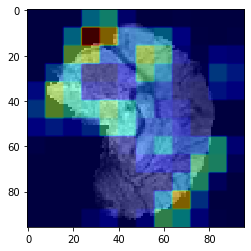

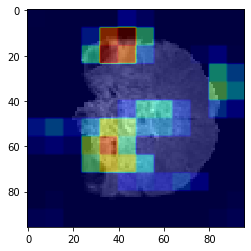

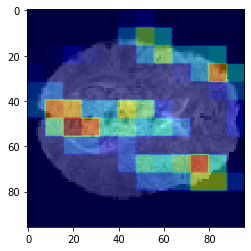

In [50]:
import matplotlib.pyplot as plt

timepoint = 0

plt.figure()
# mid-sagittal image 
plt.figure()
plt.imshow(input.numpy()[timepoint,48,:,:],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(final_map.detach().numpy()[0,48,:,:],interpolation='bilinear',cmap='jet',alpha=0.5)

# mid-scoronal image
plt.figure()
plt.imshow(input.numpy()[timepoint,:,48,:],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(final_map.detach().numpy()[0,:,48,:],interpolation='bilinear',cmap='jet',alpha=0.5)

# mid-horizontal image
plt.figure()
plt.imshow(input.numpy()[timepoint,:,:,48],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(final_map.detach().numpy()[0,:,:,48],interpolation='bilinear',cmap='jet',alpha=0.5)

<Figure size 432x288 with 0 Axes>

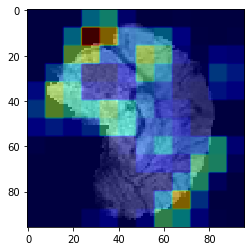

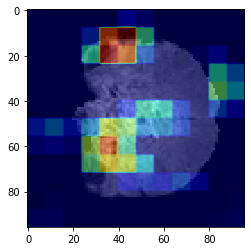

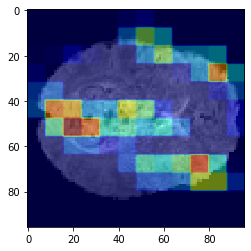

In [59]:
import matplotlib.pyplot as plt

timepoint = 9

plt.figure()
# mid-sagittal image 
plt.figure()
plt.imshow(input.numpy()[timepoint,48,:,:],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(final_map.detach().numpy()[0,48,:,:],interpolation='bilinear',cmap='jet',alpha=0.5)

# mid-scoronal image
plt.figure()
plt.imshow(input.numpy()[timepoint,:,48,:],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(final_map.detach().numpy()[0,:,48,:],interpolation='bilinear',cmap='jet',alpha=0.5)

# mid-horizontal image
plt.figure()
plt.imshow(input.numpy()[timepoint,:,:,48],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(final_map.detach().numpy()[0,:,:,48],interpolation='bilinear',cmap='jet',alpha=0.5)

### timepoint = 1

<Figure size 432x288 with 0 Axes>

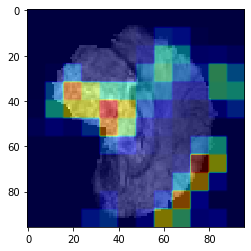

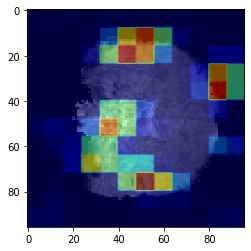

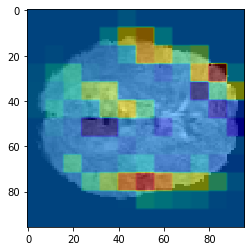

In [74]:
import matplotlib.pyplot as plt


plt.figure()
# mid-sagittal image 
plt.figure()
plt.imshow(input.numpy()[1,48,:,:],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(final_map.detach().numpy()[1,48,:,:],interpolation='bilinear',cmap='jet',alpha=0.5)

# mid-scoronal image
plt.figure()
plt.imshow(input.numpy()[1,:,48,:],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(final_map.detach().numpy()[1,:,48,:],interpolation='bilinear',cmap='jet',alpha=0.5)

# mid-horizontal image
plt.figure()
plt.imshow(input.numpy()[1,:,:,48],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(final_map.detach().numpy()[1,:,:,48],interpolation='bilinear',cmap='jet',alpha=0.5)

 ### average over all timepoints

In [45]:
input_mean = input.mean(0)
final_map_mean = final_map.mean(0)

<Figure size 432x288 with 0 Axes>

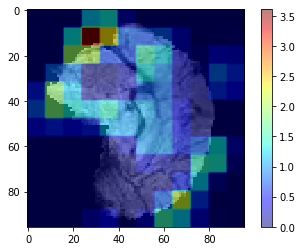

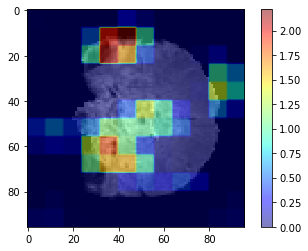

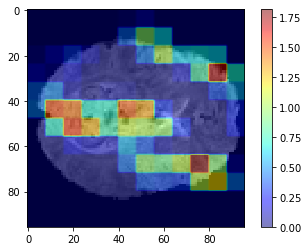

In [46]:
import matplotlib.pyplot as plt


plt.figure()
# mid-sagittal image 
plt.figure()
plt.imshow(input_mean.numpy()[48,:,:],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(final_map_mean.detach().numpy()[48,:,:],interpolation='bilinear',cmap='jet',alpha=0.5)

plt.colorbar()

# mid-scoronal image
plt.figure()
plt.imshow(input_mean.numpy()[:,48,:],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(final_map_mean.detach().numpy()[:,48,:],interpolation='bilinear',cmap='jet',alpha=0.5)

plt.colorbar()

# mid-horizontal image
plt.figure()
plt.imshow(input_mean.numpy()[:,:,48],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(final_map_mean.detach().numpy()[:,:,48],interpolation='bilinear',cmap='jet',alpha=0.5)

plt.colorbar()